In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [4]:
from uuid import uuid4

In [5]:
POS_PATH = os.path.join('data','positive')
NEG_PATH = os.path.join('data','negative')
ANC_PATH = os.path.join('data','anchor') 

In [6]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame = cap.read()
    #setting frame to 250x250px
    frame = frame[120:120+250,200:200+250,:]
    #collecting anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid4()))
        cv2.imwrite(imgname,frame)
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid4()))
        cv2.imwrite(imgname,frame)
    cv2.imshow('Image Collection' ,frame)
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
#release webcam
cap.release()
#close the image show frame
cv2.destroyAllWindows()

In [7]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(500)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(500)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(500)

In [8]:
dir_test = anchor.as_numpy_iterator()

In [9]:
print(dir_test.next())

b'data\\anchor\\17d60d7b-099d-4eb8-9a3b-aa4894ec6858.jpg'


In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Your existing preprocess function
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100, 100))
    img = img / 255.0
    return img

# Define the data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

# Function to convert tensor to numpy array for augmentation and back to tensor
def augment_image(image):
    image = tf.expand_dims(image, axis=0)  # Add batch dimension
    image = next(datagen.flow(image, batch_size=1))  # Apply augmentation
    return image[0]  # Remove batch dimension

# Function to preprocess and augment
def preprocess_and_augment(file_path):
    img = preprocess(file_path)
    img = tf.numpy_function(augment_image, [img], tf.float32)
    return img



In [11]:
img = preprocess_and_augment('data\\anchor\\7520d0f6-dc42-449e-b8e4-8097f957708e.jpg')
img.numpy().max()

0.0

In [12]:
positives = tf.data.Dataset.zip((anchor,positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [13]:
samples = data.as_numpy_iterator()

In [14]:
examples = samples.next()

In [15]:
examples

(b'data\\anchor\\ad8b3b66-a932-4b92-b415-5e03842c1c0a.jpg',
 b'data\\positive\\2e2baa30-9a02-4f09-b1ff-02c0d64669fd.jpg',
 1.0)

In [16]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [17]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size = 1024)

In [18]:
data.take(round(len(data)*.7))

<_TakeDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [19]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(32)
train_data = train_data.prefetch(16)

In [20]:
train_sample = train_data.as_numpy_iterator()

In [21]:
train_sample = train_sample.next()

In [22]:
len(train_sample)

3

In [23]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(32)
test_data = test_data.prefetch(16)

In [24]:
def make_embedding():
    inp = Input(shape=(100,100,3), name = 'input_image')
    #first block
    c1 = Conv2D(64,(10,10), activation = 'relu')(inp)
    m1 = MaxPooling2D(64,(2,2), padding = 'same')(c1)
    #second block
    c2 = Conv2D(128,(7,7), activation = 'relu')(m1)
    m2 = MaxPooling2D(64,(2,2), padding = 'same')(c2)
    #third block
    c3 = Conv2D(128,(4,4), activation = 'relu')(m2)
    m3 = MaxPooling2D(64,(2,2), padding = 'same')(c3)
    #final block of embedding
    c4 = Conv2D(256,(4,4), activation = 'relu')(m3)
    f1 = Flatten(data_format="channels_last")(c4)
    d1 = Dense(4096, activation = 'sigmoid')(f1)
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [25]:
embedding = make_embedding()

In [26]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.utils import get_custom_objects

# Suppress TensorFlow warnings
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Define your custom layer
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super(L1Dist, self).__init__(**kwargs)

    def call(self, inputs):
        x, y = inputs
        return tf.math.abs(x - y)

# Add the custom layer to custom objects
get_custom_objects().update({'L1Dist': L1Dist})

# Path to the model file
model_path = 'C:\\Users\\lkmah\\FaceID\\siamesemodel.h5'

# Check if the model file exists
if os.path.exists(model_path):
    # Load the model with custom objects
    model = tf.keras.models.load_model(model_path, custom_objects={'L1Dist': L1Dist})
    print("Model loaded successfully.")

    # Define optimizer, loss, and metrics (replace with your choices)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss = 'binary_crossentropy'  # Replace with your loss function
    metrics = ['accuracy']  # Replace with your metrics

    # Compile the model
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    print("Model compiled successfully.")
else:
    print(f"Model file not found at path: {model_path}")


Model loaded successfully.
Model compiled successfully.


In [28]:
def make_siamese_model():
    input_image = Input(name = 'input_img', shape = (100,100,3))
    validation_image = Input(name = 'validation_img', shape = (100,100,3))
    siamese_layer = L1Dist()
    siamese_layer.name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    classifier = Dense(1, activation = 'sigmoid')(distances)
    return Model(inputs=[imput_image, validation_image], outputs=classifier, name = 'SiameseNetwork')

In [29]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

class L1Dist(layers.Layer):
    def __init__(self, **kwargs):
        super(L1Dist, self).__init__(**kwargs)

    def call(self, inputs):
        # Ensure both inputs are tensors
        if not isinstance(inputs[0], tf.Tensor) or not isinstance(inputs[1], tf.Tensor):
            raise TypeError("Expected both inputs to be tensors.")

        # Calculate absolute difference
        return tf.math.abs(inputs[0] - inputs[1])

def make_siamese_model(embedding_fn):
    input_image = Input(name='input_img', shape=(100, 100, 3))
    validation_image = Input(name='validation_img', shape=(100, 100, 3))

    # Pass images through the embedding function
    encoded_input = embedding_fn(input_image)
    encoded_validation = embedding_fn(validation_image)

    # Use L1Dist layer for distance calculation
    siamese_layer = L1Dist()
    distances = siamese_layer([encoded_input, encoded_validation])

    # Add a Dense layer for classification
    classifier = layers.Dense(1, activation='sigmoid')(distances)

    # Create the Siamese network model
    model = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
    return model

# Example usage with a simple embedding function
def basic_embedding(image):
    # Replace this with your actual embedding function (e.g., convolutional layers)
    return layers.Flatten()(image)

siamese_model = make_siamese_model(basic_embedding)
# ... train and use the Siamese model

In [30]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_1 (Flatten)           │ (None, 30000)             │               0 │ input_img[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_2 (Flatten)           │ (None, 30000)             │               0 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist (L1Dist)              │ (None, 30000)             │               0 │ flatten_1[0][0],           │
│                               │                           │                 │ flatten_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1)                 │          30,001 │ l1_dist[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 30,001 (117.19 KB)

 Trainable params: 30,001 (117.19 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [32]:
opt = tf.keras.optimizers.Adam(1e-4) #0.0001

In [33]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [34]:
@tf.function

def train_step(batch):
    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]
        yhat = siamese_model(X, training=True)
        loss = binary_cross_loss(y,yhat)
    print(loss)
    grad = tape.gradient(loss,siamese_model.trainable_variables)
    opt.apply_gradients(zip(grad,siamese_model.trainable_variables))
    return loss

In [35]:
def train(data, EPOCHS):
    for epoch in range (1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(train_data))
        for idx, batch in enumerate(train_data):
            train_step(batch)
            progbar.update(idx+1)
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [36]:
EPOCHS = 50

In [37]:
import os
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.layers import Layer
from tensorflow.keras.utils import get_custom_objects

# Suppress TensorFlow warnings
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Define your custom layer
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super(L1Dist, self).__init__(**kwargs)

    def call(self, inputs):
        x, y = inputs
        return tf.math.abs(x - y)

# Add the custom layer to custom objects
get_custom_objects().update({'L1Dist': L1Dist})

def make_embedding():
    inp = Input(shape=(100, 100, 3), name='input_image')
    # First block
    c1 = layers.Conv2D(64, (10, 10), activation='relu')(inp)
    m1 = layers.MaxPooling2D(64, (2, 2), padding='same')(c1)
    # Second block
    c2 = layers.Conv2D(128, (7, 7), activation='relu')(m1)
    m2 = layers.MaxPooling2D(64, (2, 2), padding='same')(c2)
    # Third block
    c3 = layers.Conv2D(128, (4, 4), activation='relu')(m2)
    m3 = layers.MaxPooling2D(64, (2, 2), padding='same')(c3)
    # Final block of embedding
    c4 = layers.Conv2D(256, (4, 4), activation='relu')(m3)
    f1 = layers.Flatten(data_format="channels_last")(c4)
    d1 = layers.Dense(4096, activation='sigmoid')(f1)
    return Model(inputs=[inp], outputs=d1, name='embedding')

embedding = make_embedding()
embedding.summary()

def make_siamese_model(embedding_fn):
    input_image = Input(name='input_img', shape=(100, 100, 3))
    validation_image = Input(name='validation_img', shape=(100, 100, 3))

    # Pass images through the embedding function
    encoded_input = embedding_fn(input_image)
    encoded_validation = embedding_fn(validation_image)

    # Use L1Dist layer for distance calculation
    siamese_layer = L1Dist()
    distances = siamese_layer([encoded_input, encoded_validation])

    # Add a Dense layer for classification
    classifier = layers.Dense(1, activation='sigmoid')(distances)

    # Create the Siamese network model
    model = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
    return model

siamese_model = make_siamese_model(embedding)
siamese_model.summary()

# Initialize the optimizer and compile the model
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001
binary_cross_loss = tf.losses.BinaryCrossentropy()
siamese_model.compile(optimizer=opt, loss=binary_cross_loss, metrics=['accuracy'])

# Set up checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]
        yhat = siamese_model(X, training=True)
        loss = binary_cross_loss(y, yhat)
    print(loss)
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss

def train(train_data, EPOCHS):
    for epoch in range(1, EPOCHS + 1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(train_data))
        for idx, batch in enumerate(train_data):
            train_step(batch)
            progbar.update(idx + 1)
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

# Set the number of epochs
EPOCHS = 60

# Train the model
train(train_data, EPOCHS)


Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_1 (L1Dist)            │ (None, 4096)              │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_1[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)


 Epoch 1/60
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
21/22 ━━━━━━━━━━━━━━━━━━━━ 4s 5s/stepTensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
22/22 ━━━━━━━━━━━━━━━━━━━━ 106s 5s/step

 Epoch 2/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step

 Epoch 3/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 94s 4s/step

 Epoch 4/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 98s 4s/step

 Epoch 5/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step

 Epoch 6/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step

 Epoch 7/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step

 Epoch 8/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step

 Epoch 9/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step

 Epoch 10/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 111s 5s/step

 Epoch 11/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 98s 4s/step

 Epoch 12/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 97s 4s/step

 Epoch 13/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step

 Epoch 14/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step

 Epoch 15/60
22/22 ━━━━━━━━━━━━━

In [38]:
from tensorflow.keras.metrics import Precision, Recall

In [39]:
iterator = iter(test_data)
test_input, test_val, y_true = next(iterator)


In [40]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [41]:
y_hat

array([[0.5084092 ],
       [0.5084092 ],
       [0.50840926],
       [0.5084092 ],
       [0.50840926],
       [0.5084092 ],
       [0.5084092 ],
       [0.5084093 ],
       [0.5084092 ],
       [0.50840926],
       [0.50840926],
       [0.5084092 ],
       [0.5084093 ],
       [0.5084092 ],
       [0.50840926],
       [0.5084094 ],
       [0.5084093 ],
       [0.5084092 ],
       [0.50840926],
       [0.5084092 ],
       [0.50840926],
       [0.50840926],
       [0.5084093 ],
       [0.50840926],
       [0.50840926],
       [0.5084092 ],
       [0.5084092 ],
       [0.5084092 ],
       [0.5084092 ],
       [0.5084092 ],
       [0.5084092 ],
       [0.5084092 ]], dtype=float32)

In [42]:
[ 1 if prediction>0.5 else 0 for prediction in y_hat]

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [43]:
y_true

<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1.],
      dtype=float32)>

In [44]:
m = Recall()
m.update_state(y_true, y_hat)
m.result().numpy()

1.0

In [45]:
m = Precision()
m.update_state(y_true, y_hat)
m.result().numpy()

0.5625

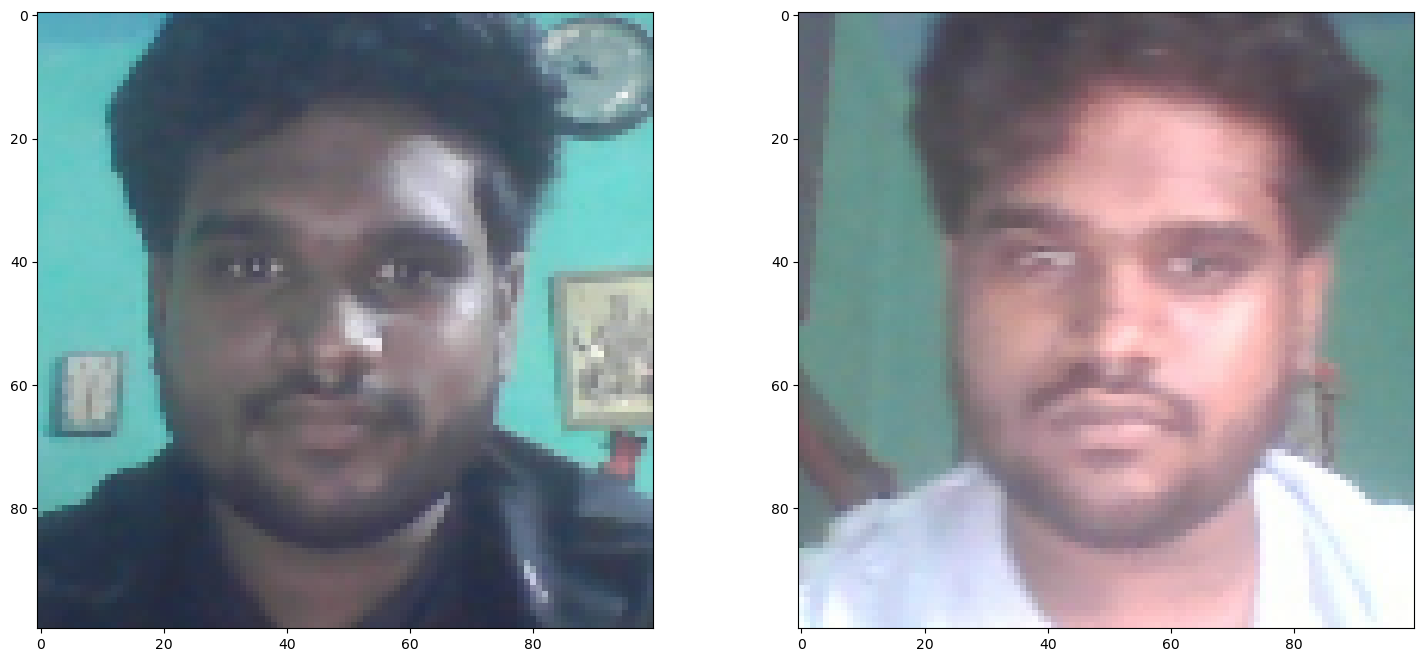

In [46]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.imshow(test_input[2])
plt.subplot(1,2,2)
plt.imshow(test_val[2])
plt.show()

In [47]:
siamese_model.save('siamesemodel.h5')

In [48]:
model = tf.keras.models.load_model('siamesemodel.h5', custom_objects = {'L1Dist':L1Dist(), 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [49]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.utils import get_custom_objects

# Define your custom layer
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super(L1Dist, self).__init__(**kwargs)

    def call(self, inputs):
        x, y = inputs
        return tf.math.abs(x - y)

# Add the custom layer to custom objects
get_custom_objects().update({'L1Dist': L1Dist})

# Path to the model file
model_path = 'C:\\Users\\lkmah\\FaceID\\siamesemodel.h5'

# Check if the model file exists
if os.path.exists(model_path):
    # Load the model with custom objects
    model = tf.keras.models.load_model(model_path, custom_objects={'L1Dist': L1Dist})
    print("Model loaded successfully.")

    # Define optimizer, loss, and metrics (replace with your choices)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss = 'binary_crossentropy'  # Replace with your loss function
    metrics = ['accuracy']  # Replace with your metrics

    # Compile the model
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    print("Model compiled successfully.")
else:
    print(f"Model file not found at path: {model_path}")


Model loaded successfully.
Model compiled successfully.


In [50]:
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


array([[0.5084092 ],
       [0.5084092 ],
       [0.50840926],
       [0.5084092 ],
       [0.50840926],
       [0.5084092 ],
       [0.5084092 ],
       [0.5084093 ],
       [0.5084092 ],
       [0.50840926],
       [0.50840926],
       [0.5084092 ],
       [0.5084093 ],
       [0.5084092 ],
       [0.50840926],
       [0.5084094 ],
       [0.5084093 ],
       [0.5084092 ],
       [0.50840926],
       [0.5084092 ],
       [0.50840926],
       [0.50840926],
       [0.5084093 ],
       [0.50840926],
       [0.50840926],
       [0.5084092 ],
       [0.5084092 ],
       [0.5084092 ],
       [0.5084092 ],
       [0.5084092 ],
       [0.5084092 ],
       [0.5084092 ]], dtype=float32)

In [51]:
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_1 (L1Dist)            │ (None, 4096)              │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_1[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
model

<Functional name=SiameseNetwork, built=True>

In [53]:
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_1 (L1Dist)            │ (None, 4096)              │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_1[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
def verify(model, detection_threshold, verification_threshold):
    results=[]
    for image in os.listdir(os.path.join('application_data','verification_images')):
        input_img = preprocess_and_augment(os.path.join('application_data','input_image','input_image.jpg'))
        validation_img = preprocess_and_augment(os.path.join('application_data','verification_images', image))
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis = 1)))
        results.append(result)
    detection = np.sum(np.array(results) > detection_threshold)
    verification = detection / len(os.listdir(os.path.join('application_data','verification_images')))
    verified = verification > verification_threshold
    return results, verified

In [55]:
import cv2
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250,:]
    cv2.imshow('Verification', frame)
    if cv2.waitKey(10) & 0xFF == ord('v'):
        cv2.imwrite(os.path.join('application_data','input_image','input_image.jpg'), frame)
        results, verified = verify(model,0.9,0.7)
        print(verified)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 